### Importing

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, BatchNormalization,Dropout
import matplotlib.pyplot as plt
from keras import callbacks
import numpy as np

### Image Augmentation

In [3]:
from keras.preprocessing.image import ImageDataGenerator

batch_size=32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = val_datagen.flow_from_directory(
        '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [4]:
# Generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train',
    labels='inferred',
    batch_size=32,
    image_size=(224,224),

)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation',
    labels='inferred',
    batch_size=32,
    image_size=(224,224),

)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names

In [6]:
class_names

['WithMask', 'WithoutMask']

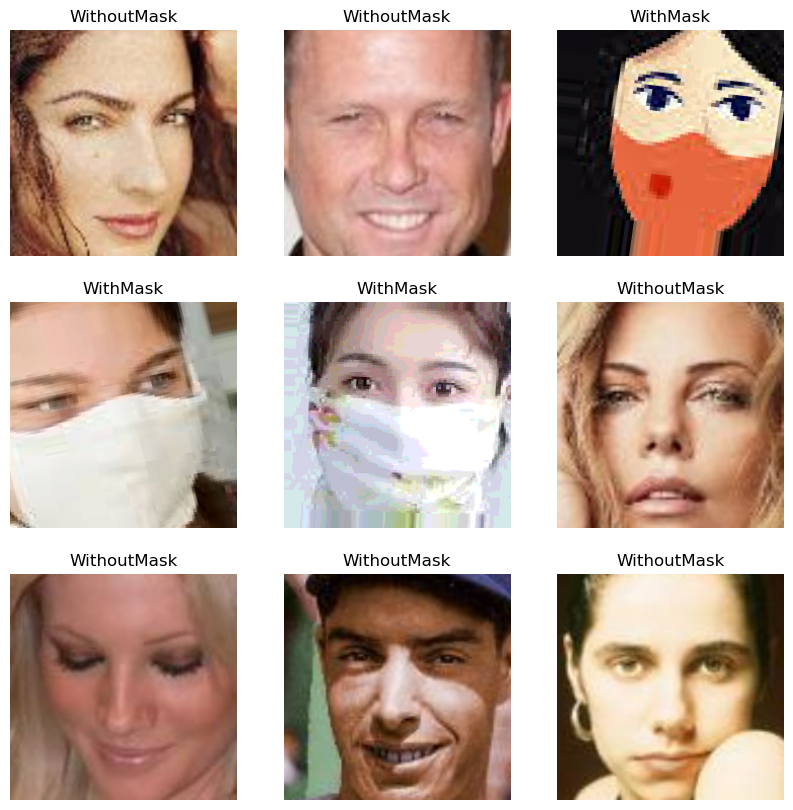

In [7]:
# Looking into the sample data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [9]:
# Normalize the image to bring it down to a size between (0,1)
def process_image(image, label):
    image = tf.cast(image/255. , tf.float32)
    return image, label

train_ds = train_ds.map(process_image)
validation_ds = validation_ds.map(process_image)

### **Creating a base model**

In [10]:
# Create CNN Model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Fit the model
history = model.fit(train_ds,epochs=40, validation_data=validation_ds)

Epoch 1/40
313/313 [==============================] - 61s 158ms/step - loss: 0.1368 - accuracy: 0.9513 - val_loss: 0.1052 - val_accuracy: 0.9550
Epoch 2/40
313/313 [==============================] - 25s 77ms/step - loss: 0.0495 - accuracy: 0.9832 - val_loss: 0.0319 - val_accuracy: 0.9900
Epoch 3/40
313/313 [==============================] - 25s 78ms/step - loss: 0.0277 - accuracy: 0.9900 - val_loss: 0.0333 - val_accuracy: 0.9912
Epoch 4/40
313/313 [==============================] - 25s 77ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.0394 - val_accuracy: 0.9887
Epoch 5/40
313/313 [==============================] - 24s 77ms/step - loss: 0.0275 - accuracy: 0.9902 - val_loss: 0.0628 - val_accuracy: 0.9850
Epoch 6/40
313/313 [==============================] - 26s 82ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0228 - val_accuracy: 0.9925
Epoch 7/40
313/313 [==============================] - 24s 76ms/step - loss: 0.0190 - accuracy: 0.9922 - val_loss: 0.0385 - val_accuracy

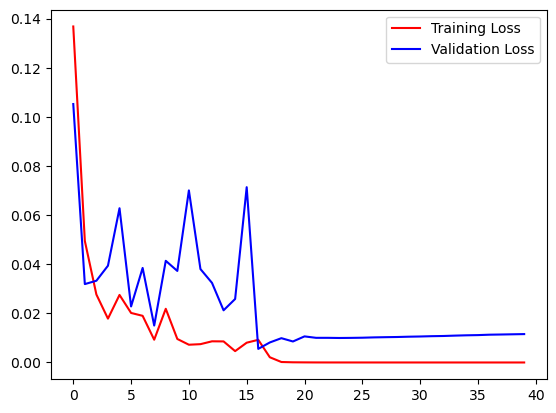

In [14]:
# Comparing loss
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()
plt.show()

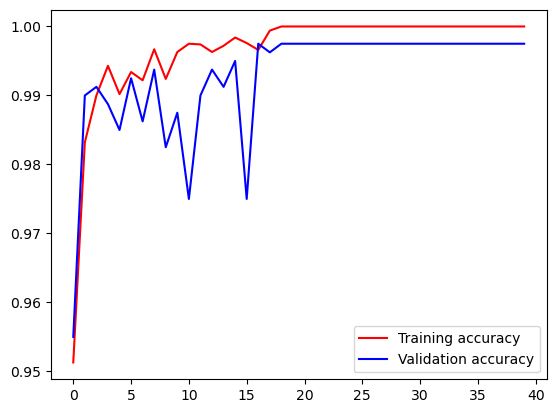

In [15]:
# Comparing accuracy
plt.plot(history.history['accuracy'], label='Training accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.legend()
plt.show()

### ***Creating a VGG16 Model***

In [16]:
# Create a VGG model
from keras.applications.vgg16 import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
model_vgg = Sequential()
model_vgg.add(conv_base)
model_vgg.add(Flatten())
model_vgg.add(Dense(256,activation='relu'))
model_vgg.add(Dense(1,activation='sigmoid'))

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [18]:
conv_base.trainable = False

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
model_vgg.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
history_aug = model_vgg.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator)

Epoch 1/10
313/313 [==============================] - 158s 495ms/step - loss: 0.1106 - accuracy: 0.9672 - val_loss: 0.0201 - val_accuracy: 0.9937
Epoch 2/10
313/313 [==============================] - 154s 491ms/step - loss: 0.0365 - accuracy: 0.9892 - val_loss: 0.0098 - val_accuracy: 0.9975
Epoch 3/10
313/313 [==============================] - 152s 487ms/step - loss: 0.0303 - accuracy: 0.9890 - val_loss: 0.0149 - val_accuracy: 0.9962
Epoch 4/10
313/313 [==============================] - 153s 488ms/step - loss: 0.0353 - accuracy: 0.9877 - val_loss: 0.0153 - val_accuracy: 0.9950
Epoch 5/10
313/313 [==============================] - 151s 482ms/step - loss: 0.0227 - accuracy: 0.9917 - val_loss: 0.0115 - val_accuracy: 0.9962
Epoch 6/10
313/313 [==============================] - 151s 483ms/step - loss: 0.0259 - accuracy: 0.9906 - val_loss: 0.0079 - val_accuracy: 0.9975
Epoch 7/10
313/313 [==============================] - 151s 481ms/step - loss: 0.0301 - accuracy: 0.9898 - val_loss: 0.0215 -

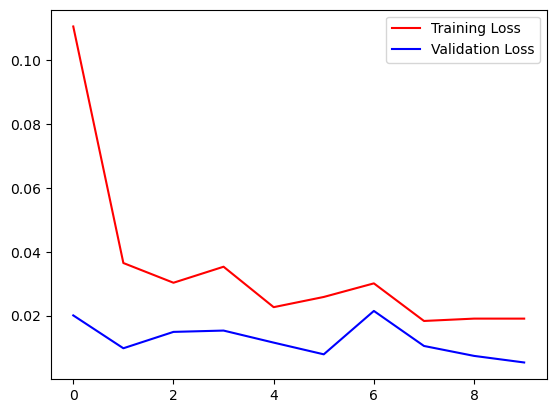

In [21]:
# Comparing loss using vgg16
plt.plot(history_aug.history['loss'], label='Training Loss', color='red')
plt.plot(history_aug.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()
plt.show()

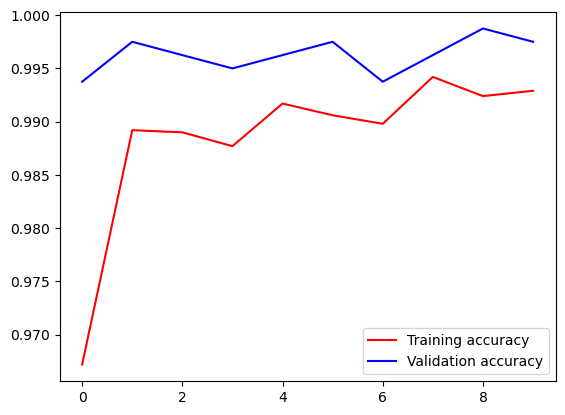

In [22]:
# Comparing accuracy
plt.plot(history_aug.history['accuracy'], label='Training accuracy', color='red')
plt.plot(history_aug.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.legend()
plt.show()

### Evaluating Test Data

In [24]:
# Evaluating on test data
test_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test',
    labels='inferred',
    batch_size=32,
    image_size=(224,224),
    shuffle=False

)

Found 992 files belonging to 2 classes.


In [25]:
test_ds = test_ds.map(process_image)

In [26]:
test_score = model_vgg.evaluate(test_ds)

print(test_score[1])


31/31 [==============================] - 5s 163ms/step - loss: 0.0467 - accuracy: 0.9829
0.9828628897666931


In [27]:
y_preds = model_vgg.predict(test_ds)

31/31 [==============================] - 5s 158ms/step


In [29]:
y_preds=y_preds.flatten().astype('int32')

In [30]:
y_test = np.concatenate([y for x, y in test_ds], axis=0) 

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

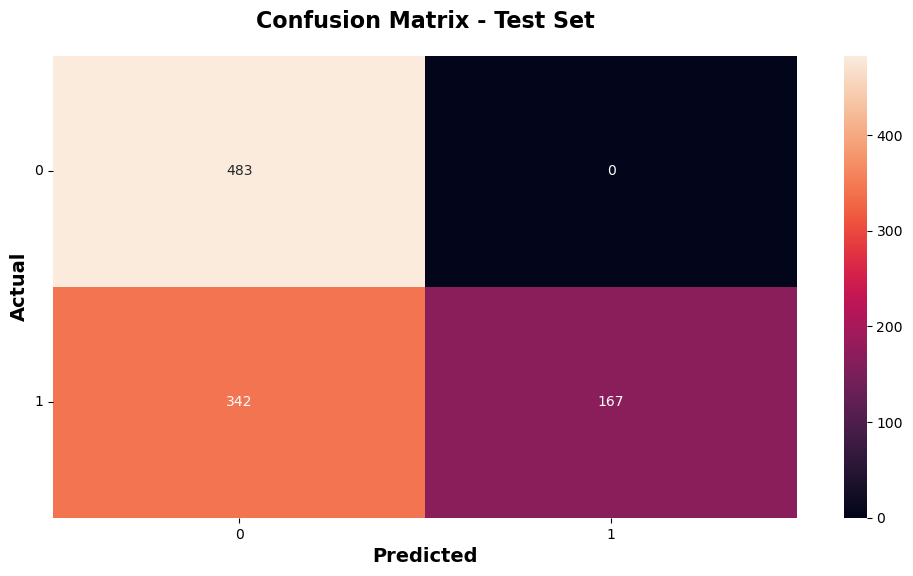

In [31]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import seaborn as sns

#ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_preds);
#test_pred = model.predict(test_ds)
#test_pred = np.argmax(test_pred,axis = 1)
#test_labels = np.concatenate([y for x, y in test_ds], axis=0) 

plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    y_test,
    y_preds,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

### Video Capture

In [32]:
import cv2
cap = cv2.VideoCapture(0)

[ WARN:0] global /tmp/pip-req-build-jpmv6t9_/opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


In [33]:
def draw_label(img,text,pos,bg_color):
  text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX,1, cv2.FILLED)

  end_x = pos[0] + text_size[0][0] + 2
  end_y = pos[1] + text_size[0][1] - 2

  cv2.rectangle(img, pos, (end_x,end_y), bg_color, cv2.FILLED)
  cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AA)

In [34]:
def detect_face_mask(img):
    y_pred = model_vgg.predict(img.reshape(1,224,224,3), verbose=0)
    #y_pred = model_vgg.predict(img, verbose=0)
  #np.where(y_pred[0][0] > 0.5, 1,0)
  #y_pred = (model.predict(img.reshape(1,224,224,3), verbose=0) > 0.5).astype("int32")
    if y_pred[0][0] >= 0.5:
        return 1
    else:
        return 0

In [35]:
sample_1 = cv2.imread('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1001.png')
sample_1 = cv2.resize(sample_1,(224,224))
sample_mask_img = np.reshape(sample_1,[1,224,224,3])
sample_mask_img = sample_mask_img/255.0

In [36]:
detect_face_mask(sample_mask_img)

1

**Use below code for Mask Detection on Live webcam video**

In [38]:
# cap = cv2.VideoCapture(0)
# while True:
#     ret, frame = cap.read()
        
#     #Call the detection method
#     img = cv2.resize(frame, (224,224),3)
#     y_pred = detect_face_mask(img)
    
#     if y_pred == 0:
#         draw_label(frame, "Mask", (30,30), (0,255,0))
#     else:
#         draw_label(frame, "No Mask", (30,30), (0,0,255))

#     cv2.imshow("window", frame)
    
#     if cv2.waitKey(1) & 0xFF == ord('x'):
#         break
# cap.release()
# cv2.destroyAllWindows()